In [36]:
import pandas as pd
import numpy as np

## Model data preparation

In [37]:
population = 36648727 # from Keralastat.com - is this reliable?
number_hospital_beds = 38004
number_icu_beds = 3742

average_R0 = 3

tl = 5 * (24 * 3600)
ti = 10 * (24 * 3600)
th = 4 * (24 * 3600)
tc = 14 * (24 * 3600)

In [38]:
simulation_start_date = "2020-03-01"
simulation_end_date = "2020-05-31"

In [39]:
# The agewise split is taken from http://statisticstimes.com/demographics/population-of-kerala.php

zetaa = pd.DataFrame()
ma = pd.DataFrame()
fa = pd.DataFrame()
ca = pd.DataFrame()
sa0 = pd.DataFrame()

CONVERT_PERCENTAGE = 1
CONVERT_TO_ABS_POPULATION = 0
sa0_file = "./data/population_age_distribution.csv"
ma_file = "./data/agebased_recovery.csv"
ca_file = "./data/agebased_criticalcare.csv"
fa_file = "./data/agebased_fatal.csv"
zetaa_file = "./data/agebased_zetaa.csv"

age_map_dict = {0:"0-9",1:"10-19",
    2:"20-29", 3:"30-39",
    4:"40-49", 5:"50-59",
    6:"60-69", 7:"70-79",
    8:"80-"}
age_code_end = 9

agestring = pd.DataFrame.from_dict(age_map_dict, orient="index")
agestring.columns = ["AgeString"]

zero_initial_value = np.zeros(age_code_end)

infected_initial_value_dict = {0:0,1:0,
    2:2, 3:3,
    4:4, 5:4,
    6:2, 7:0,
    8:0}
infected_initial_value = pd.DataFrame.from_dict(infected_initial_value_dict, orient="index")
infected_initial_value.columns = ["Value"]

In [40]:
def prepare_agebased_data_fromfile(file):
    filedata = pd.read_csv(file, index_col=0)
    var = pd.DataFrame(columns=["AgeString","Value"])    
    var["AgeString"] = agestring["AgeString"]
    if CONVERT_PERCENTAGE:
        var["Value"] = filedata["Value"]/100
    else:
        var["Value"] = filedata["Value"]
        
    if CONVERT_TO_ABS_POPULATION:
        var["Value"] = var["Value"] * population
    
    return var


def prepare_timeseries_data(initial_value):
    var = np.zeros((1, len(initial_value)))
    var[0,:] = initial_value
    return var

In [41]:
ma = prepare_agebased_data_fromfile(ma_file)
ca = prepare_agebased_data_fromfile(ca_file)
fa = prepare_agebased_data_fromfile(fa_file)
zetaa = prepare_agebased_data_fromfile(zetaa_file)

CONVERT_TO_ABS_POPULATION = 1
sa0 = prepare_agebased_data_fromfile(sa0_file)

In [60]:
Sa = prepare_timeseries_data(sa0["Value"].values)
Ia = prepare_timeseries_data(infected_initial_value["Value"].values)
Ea = prepare_timeseries_data(zero_initial_value)
Ha = prepare_timeseries_data(zero_initial_value)
Ca = prepare_timeseries_data(zero_initial_value)
Ra = prepare_timeseries_data(zero_initial_value)
Da = prepare_timeseries_data(zero_initial_value)
betat = prepare_timeseries_data(zero_initial_value)

## Model simulation

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
dt = 3600 # this is in units of seconds

In [45]:
total_seconds_of_simulation = (pd.Timestamp(simulation_end_date) - pd.Timestamp(simulation_start_date)).total_seconds()

In [46]:
total_simtime_steps = int(np.ceil(total_seconds_of_simulation / dt))

In [47]:
def limit(value):
    return np.min([population, np.max([value, 0])])

def apply_limit(array):
    return np.array([limit(x) for x in array])


In [62]:
for sim_time in range(total_simtime_steps):        
    total_infected = np.sum(Ia[sim_time, :])
    betat[sim_time, :] = average_R0 * (1 - zetaa["Value"].values)/population
    betat = np.vstack([betat, zero_initial_value])
    Sa = np.vstack([Sa, apply_limit(Sa[sim_time, :] - dt * (betat[sim_time, :] * Sa[sim_time, :] * total_infected))])
    Ea = np.vstack([Ea, apply_limit(Ea[sim_time, :] + dt * (betat[sim_time, :] * Sa[sim_time, :] * total_infected - \
                                   Ea[sim_time, :]/tl))])
    Ia = np.vstack([Ia, apply_limit(Ia[sim_time, :] + dt * (Ea[sim_time, :]/tl - Ia[sim_time, :]/ti))])
    Ha = np.vstack([Ha, apply_limit(Ha[sim_time, :] + dt * (ma["Value"].values/ti * Ia[sim_time, :] + \
                                                           (1 - fa["Value"].values)/tc * Ca[sim_time, :] - \
                                                           Ha[sim_time, :]/th))])
    Ca = np.vstack([Ca, apply_limit(Ca[sim_time, :] + dt * (ca["Value"].values * Ha[sim_time, :]/th - \
                                                           Ca[sim_time, :]/tc))])
    Ra = np.vstack([Ra, apply_limit(Ra[sim_time, :] + dt * ((1 - ma["Value"].values)/ti * Ia[sim_time, :] + \
                                                           (1 - ca["Value"].values) * Ha[sim_time, :]/th))])
    Da = np.vstack([Da, apply_limit(Da[sim_time, :] + dt * (fa["Value"].values * Ca[sim_time, :]))])

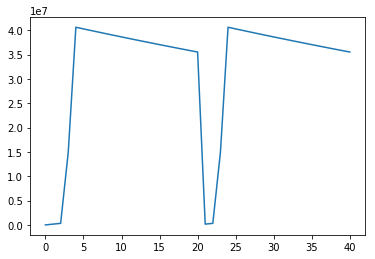

In [63]:
plt.plot(np.sum(Ea, axis = 1))